In [6]:
pip install --upgrade yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.8/109.8 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.50
    Uninstalling yfinance-0.2.50:
      Successfully uninstalled yfinance-0.2.50
Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas as pd
import yfinance as yf
import numpy as np
import datetime
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from matplotlib.dates import DateFormatter
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
import torch
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [9]:
# Functions for calculating indicators (SMA, RSI, etc.) and generating trading signals

def calculate_sma(df, window):
    return df['Close'].rolling(window=window).mean()

def calculate_ema(df, window):
    return df['Close'].ewm(span=window, adjust=False).mean()

def calculate_macd(df):
    short_ema = df['Close'].ewm(span=12, adjust=False).mean()
    long_ema = df['Close'].ewm(span=26, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=9, adjust=False).mean()
    return macd, signal

def calculate_rsi(df):
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_bollinger_bands(df):
    middle_bb = df['Close'].rolling(window=20).mean()
    upper_bb = middle_bb + 2 * df['Close'].rolling(window=20).std()
    lower_bb = middle_bb - 2 * df['Close'].rolling(window=20).std()
    return middle_bb, upper_bb, lower_bb

def calculate_stochastic_oscillator(df):
    lowest_low = df['Low'].rolling(window=14).min()
    highest_high = df['High'].rolling(window=14).max()
    slowk = ((df['Close'] - lowest_low) / (highest_high - lowest_low)) * 100
    slowd = slowk.rolling(window=3).mean()
    return slowk, slowd

def calculate_cmf(df, window=20):
    mfv = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low']) * df['Volume']
    cmf = mfv.rolling(window=window).sum() / df['Volume'].rolling(window=window).sum()
    return cmf

def calculate_cci(df, window=20):
    """Calculate Commodity Channel Index (CCI)."""
    typical_price = (df['High'] + df['Low'] + df['Close']) / 3
    sma = typical_price.rolling(window=window).mean()
    mean_deviation = (typical_price - sma).abs().rolling(window=window).mean()
    cci = (typical_price - sma) / (0.015 * mean_deviation)
    return cci

# Function to generate trading signals
def generate_trading_signals(df):
    df['SMA_30'] = calculate_sma(df, 30)
    df['SMA_100'] = calculate_sma(df, 100)
    df['EMA_12'] = calculate_ema(df, 12)
    df['EMA_26'] = calculate_ema(df, 26)
    df['RSI'] = calculate_rsi(df)
    df['MiddleBB'], df['UpperBB'], df['LowerBB'] = calculate_bollinger_bands(df)
    df['SlowK'], df['SlowD'] = calculate_stochastic_oscillator(df)
    df['CMF'] = calculate_cmf(df)
    df['CCI'] = calculate_cci(df)
    macd, signal = calculate_macd(df)
    df['MACD'] = macd
    df['MACD_Signal_Line'] = signal
    return df


In [10]:
import numpy as np
import pandas as pd
import yfinance as yf
import torch

def apply_triple_barrier(close_prices, pt_pct, sl_pct, horizon):
    """
    Applies the Triple-Barrier method to classify stock trends.
    Labels:
    - 1 = Uptrend (profit target reached first)
    - -1 = Downtrend (stop loss reached first)
    - 0 = No trend (neither barrier reached within horizon)
    """
    labels = np.zeros(len(close_prices))  # Default label is 0 (no trend)
    
    for i in range(len(close_prices) - horizon):
        start_price = close_prices[i]
        future_prices = close_prices[i + 1 : i + horizon + 1]
        
        upper_barrier = start_price * (1 + pt_pct)  # Profit target
        lower_barrier = start_price * (1 - sl_pct)  # Stop loss
        
        # Check when the price first hits an upper or lower barrier
        hit_upper = np.where(future_prices >= upper_barrier)[0]
        hit_lower = np.where(future_prices <= lower_barrier)[0]

        if len(hit_upper) > 0 and (len(hit_lower) == 0 or hit_upper[0] < hit_lower[0]):
            labels[i] = 1  # Uptrend
        elif len(hit_lower) > 0:
            labels[i] = 0  # Downtrend (-1)
        else:
            labels[i] = 0  # No trend
    
    return labels


def prepare_ml_data(ticker, start_date, end_date, pt_pct=0.02, sl_pct=0.02, horizon=15):
    """
    Prepares stock data for trend classification using the Triple-Barrier method.
    
    Parameters:
        ticker (str): Stock ticker symbol.
        start_date (str): Start date for data download.
        end_date (str): End date for data download.
        pt_pct (float): Profit target percentage (default: 2%).
        sl_pct (float): Stop loss percentage (default: 2%).
        horizon (int): Maximum holding period (default: 15 days).
    
    Returns:
        df (pd.DataFrame): DataFrame with 'Trend' column (-1 for downtrend, 0 for no trend, 1 for uptrend).
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    df = yf.download(ticker, start=start_date, end=end_date)
    
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    
    if 'Adj Close' in df.columns:
        df = df.drop('Adj Close', axis=1)
        

    close = torch.tensor(df['Close'].values, dtype=torch.float32).to(device)
    close = close.view(1, 1, -1)
    
    windows = torch.nn.functional.unfold(close, 
                                         kernel_size=(1, window_size), 
                                         stride=1)
    
    windows = windows.squeeze(0).transpose(0, 1)
    
    x = torch.arange(window_size, dtype=torch.float32).to(device)
    sum_x = torch.sum(x)
    sum_x_sq = torch.sum(x ** 2)
    denominator = window_size * sum_x_sq - sum_x ** 2
    
    sum_y = torch.sum(windows, dim=1)
    sum_xy = torch.sum(windows * x, dim=1)
    numerator = window_size * sum_xy - sum_x * sum_y
    slopes = numerator / denominator
    
    slopes_cpu = slopes.cpu().numpy()
    
    future_slopes = np.full(len(df), np.nan)
    future_slopes[:len(slopes_cpu)] = slopes_cpu
    df = df.assign(Future_Slope=future_slopes)
    
    mean_slope = np.nanmean(df['Future_Slope'])
    df['Future_Slope'] = df['Future_Slope'].fillna(mean_slope)
    
    # Binary Classification: 1 for Uptrend, 0 for Downtrend
    df['Up'] = (df['Future_Slope'] > 0).astype(int)




    
    
    close_prices = df['Close'].values

    
    
    df['Trend'] = apply_triple_barrier(close_prices, pt_pct, sl_pct, horizon)
    
    return df


In [11]:
def visualize_trends(df, ticker, window_size):
    """
    Creates visualizations of the stock data and binary trend classifications.
    
    Parameters:
        df (pd.DataFrame): Processed DataFrame with trend information
        ticker (str): Stock ticker symbol
        window_size (int): Window size used for slope calculation
    """
    # Create a figure with subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15), gridspec_kw={'height_ratios': [3, 1, 1]})
    
    # Plot 1: Price and trend
    ax1.plot(df.index, df['Close'], label='Close Price', color='black', alpha=0.7)
    
    # Color regions based on trend
    up_mask = df['Trend'] == 1
    down_mask = df['Trend'] == 0
    
    # Plot colored backgrounds for trend periods
    for trend, mask, color in [('Uptrend', up_mask, 'lightgreen'), 
                               ('Downtrend', down_mask, 'lightcoral')]:
        # Find consecutive periods
        if mask.any():
            trend_periods = []
            period_start = None
            
            for i, val in enumerate(mask):
                if val and period_start is None:
                    period_start = i
                elif not val and period_start is not None:
                    trend_periods.append((period_start, i-1))
                    period_start = None
            
            # Handle the case where the last period extends to the end
            if period_start is not None:
                trend_periods.append((period_start, len(mask)-1))
            
            # Shade each period
            for start, end in trend_periods:
                if start < len(df.index) and end < len(df.index):
                    ax1.axvspan(df.index[start], df.index[end], alpha=0.2, color=color)
    
    # Customize plot 1
    ax1.set_title(f'{ticker} Stock Price with Binary Trend Classification (Window: {window_size})')
    ax1.set_ylabel('Price ($)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Future Slope values
    ax2.plot(df.index, df['Future_Slope'], color='darkblue')
    ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.5, label='Neutral Slope')
    ax2.set_ylabel('Slope')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Trend distribution
    trend_counts = df['Trend'].value_counts()
    colors = {1: 'purple', 0: 'lightcoral'}
    sns.barplot(x=trend_counts.index, y=trend_counts.values, palette=colors, ax=ax3)
    ax3.set_title('Distribution of Trend Classifications')
    ax3.set_ylabel('Count')
    
    # Add percentages on top of bars
    total = len(df)
    for i, count in enumerate(trend_counts):
        percentage = 100 * count / total
        ax3.text(i, count + 5, f'{percentage:.1f}%', ha='center')
    
    # Format date on x-axis
    date_form = DateFormatter("%Y-%m-%d")
    ax1.xaxis.set_major_formatter(date_form)
    ax2.xaxis.set_major_formatter(date_form)
    
    plt.tight_layout()
    plt.show()
    
    # Additional plot: Confusion matrix-style visualization of trend transitions
    plt.figure(figsize=(6, 4))
    
    # Create transition matrix
    transitions = pd.crosstab(df['Trend'].shift(), df['Trend'], 
                             rownames=['From'], colnames=['To'],
                             normalize='index')
    
    # Rename the labels
    labels = ['Down', 'Up']
    
    # Plot heatmap
    sns.heatmap(transitions, annot=True, cmap='Purples', fmt='.1%', 
                xticklabels=labels, yticklabels=labels, cbar_kws={'label': 'Transition Probability'})
    
    plt.title('Trend Transition Probabilities')
    plt.tight_layout()
    plt.show()

In [12]:
# Define parameters
ticker = "BABA"
start_date = "2021-01-01"
end_date = "2026-01-01"
window_size = 15

df = yf.download(ticker, start=start_date, end=end_date)
    
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)
    
if 'Adj Close' in df.columns:
    df = df.drop('Adj Close', axis=1)
    

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [13]:
df

Price,Close,High,Low,Open,Volume
Date,,,,,
2021-01-04,220.045380,222.488717,217.331619,218.741616,24897900
2021-01-05,232.165482,232.513151,220.306114,221.204266,35823800
2021-01-06,219.813583,230.137417,218.123527,226.902160,37146100
2021-01-07,219.127899,222.073429,212.551167,221.455352,49361800
2021-01-08,228.099701,230.427154,218.918344,220.074349,34884900
...,...,...,...,...,...
2025-03-20,136.910004,138.990005,136.369995,137.175003,23646800
2025-03-21,135.139999,136.470001,133.300003,133.990005,13970300
2025-03-24,134.479996,136.429993,133.630005,136.330002,14019000


## **Preprocess Data**

In [14]:
# Define parameters
ticker = "BABA"
start_date = "2020-01-01"
end_date = "2026-01-01"
window_size = 15

# Example usage
df = prepare_ml_data('BABA', start_date, end_date, horizon=window_size)

[*********************100%***********************]  1 of 1 completed


Using device: cuda


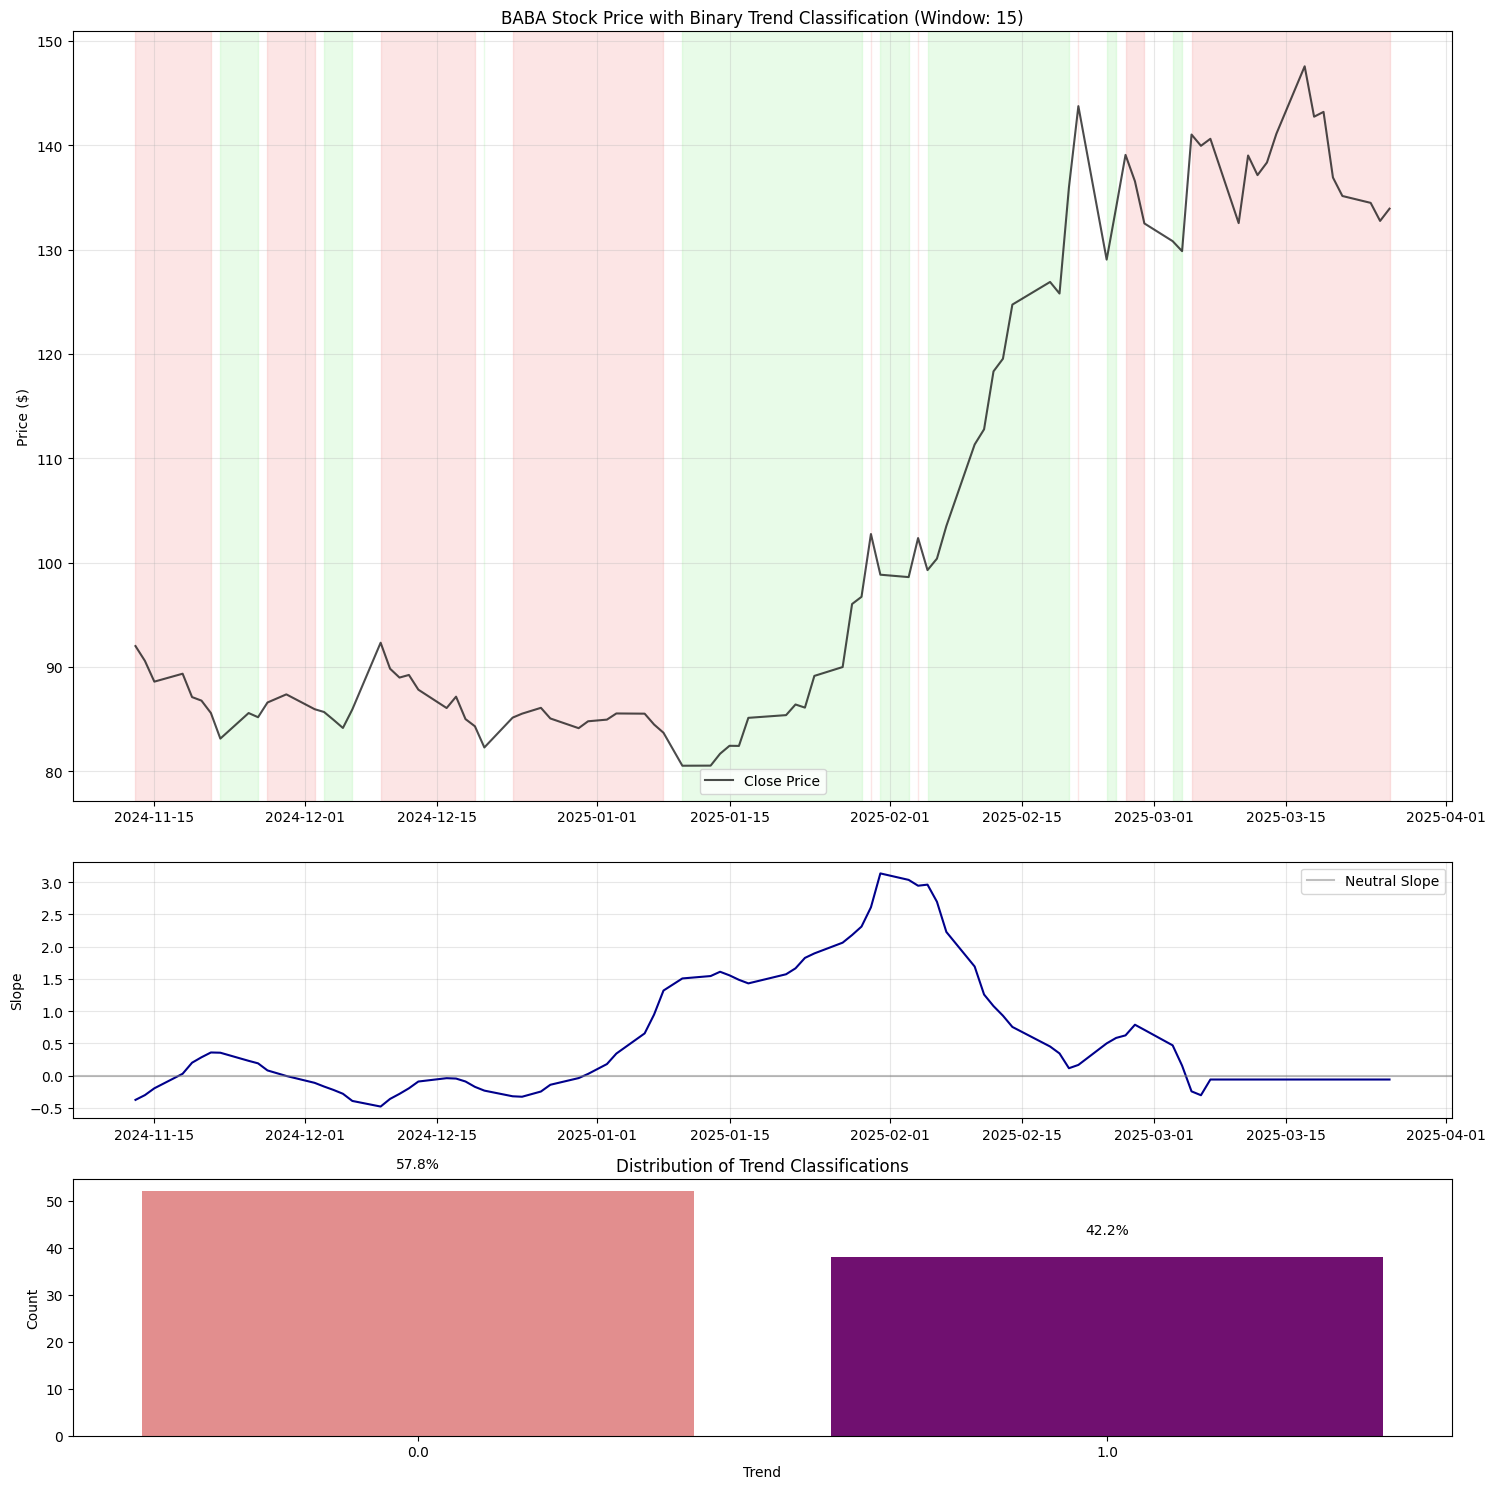

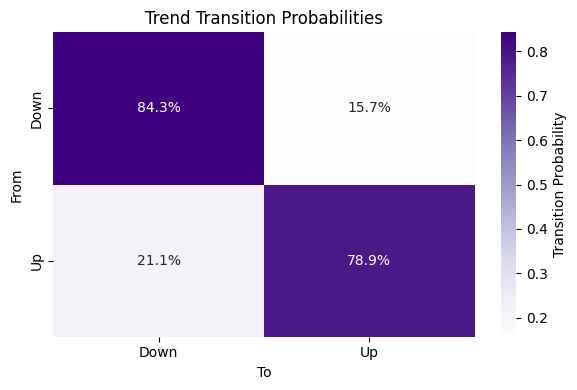

In [15]:
visualize_trends(df.tail(90), ticker, window_size)

In [16]:
# Generate indicators
data = generate_trading_signals(df)

In [17]:
data

Price,Close,High,Low,Open,Volume,Future_Slope,Up,Trend,SMA_30,SMA_100,...,RSI,MiddleBB,UpperBB,LowerBB,SlowK,SlowD,CMF,CCI,MACD,MACD_Signal_Line
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,212.242126,212.444925,209.122754,209.180712,15873500,0.421064,1,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
2020-01-03,209.567017,210.728813,208.610922,208.939287,8604500,0.154107,1,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.213399,-0.042680
2020-01-06,209.219345,209.721537,206.756688,207.529289,11885500,-0.368452,0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.405895,-0.115323
2020-01-07,210.175446,211.440571,209.267641,210.185098,9388000,-0.746213,0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.475815,-0.187421
2020-01-08,210.532761,213.091983,208.910313,209.180721,11959100,-1.031347,0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.496669,-0.249271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-20,136.910004,138.990005,136.369995,137.175003,23646800,-0.058487,0,0.0,131.167334,102.05360,...,54.071067,137.788500,147.876013,127.700988,48.410246,66.502496,-0.101065,-2.739589,7.059512,8.251631
2025-03-21,135.139999,136.470001,133.300003,133.990005,13970300,-0.058487,0,0.0,132.326000,102.44140,...,54.001110,137.358000,147.103374,127.612626,40.483669,55.157507,-0.140456,-16.730952,6.227574,7.846820
2025-03-24,134.479996,136.429993,133.630005,136.330002,14019000,-0.058487,0,0.0,133.358334,102.81200,...,54.302164,137.630000,146.676459,128.583541,19.965560,36.286492,-0.049366,-20.489011,5.452151,7.367886


In [18]:
# INFO

# Display the shape of the data
print("Data Shape:")
print(data.shape)


# Check for missing values
missing_columns = data.columns[data.isnull().any()]
if missing_columns.size > 0:
    missing_values = data[missing_columns].isnull().sum()
    missing_percentage = (missing_values / len(df)) * 100

    # Combine missing_values and missing_percentage into a single DataFrame
    missing_data = pd.concat([missing_values, missing_percentage], axis=1, keys=['Total', 'Percent'])

    # Sort the missing_data DataFrame by Total column in descending order
    missing_data = missing_data.sort_values(by='Total', ascending=False)

    # Print missing data
    print("\nMissing Data:")
    print(missing_data.to_string())
else:
    print("\nNo Missing Values Found")

Data Shape:
(1315, 22)

Missing Data:
          Total   Percent
Price                    
SMA_100      99  7.528517
CCI          38  2.889734
SMA_30       29  2.205323
MiddleBB     19  1.444867
LowerBB      19  1.444867
UpperBB      19  1.444867
CMF          19  1.444867
SlowD        15  1.140684
RSI          13  0.988593
SlowK        13  0.988593


In [19]:
# View the last few rows with the new categorical column
data[['Close', 'Future_Slope', 'Trend']].sample(5)

Price,Close,Future_Slope,Trend
Date,,,
2022-02-08,117.724510,-1.499665,1.0
2022-07-14,100.205872,-0.878899,0.0
2023-12-08,69.668961,0.531438,1.0
2023-01-23,115.435692,-1.248605,0.0
2021-11-26,128.782318,-0.406068,0.0


In [20]:
data.columns

Index(['Close', 'High', 'Low', 'Open', 'Volume', 'Future_Slope', 'Up', 'Trend',
       'SMA_30', 'SMA_100', 'EMA_12', 'EMA_26', 'RSI', 'MiddleBB', 'UpperBB',
       'LowerBB', 'SlowK', 'SlowD', 'CMF', 'CCI', 'MACD', 'MACD_Signal_Line'],
      dtype='object', name='Price')

In [21]:
data = data.dropna()

In [22]:
data

Price,Close,High,Low,Open,Volume,Future_Slope,Up,Trend,SMA_30,SMA_100,...,RSI,MiddleBB,UpperBB,LowerBB,SlowK,SlowD,CMF,CCI,MACD,MACD_Signal_Line
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-26,194.810410,199.716404,194.115071,198.885861,28683200,1.388505,1,1.0,197.490354,199.190166,...,56.252335,195.902667,210.386170,181.419165,28.348151,40.267538,-0.137054,1.738692,1.865514,1.834988
2020-05-27,194.288910,196.036924,190.010659,196.036924,23605400,1.291615,1,1.0,197.374465,199.010634,...,55.567910,195.904116,210.386932,181.421300,26.357527,25.202440,-0.100464,-32.730342,1.372105,1.742412
2020-05-28,192.656799,195.438140,190.850843,192.183578,18763200,1.147106,1,1.0,197.095042,198.841532,...,52.760391,195.555965,209.997398,181.114531,20.127573,24.944417,-0.141947,-35.408588,0.839697,1.561869
2020-05-29,200.286194,200.759415,189.962360,193.149327,43179500,0.859234,1,1.0,196.925393,198.752200,...,55.387554,195.783881,210.379792,181.187971,49.249847,31.911649,-0.053842,15.514808,1.021613,1.453818
2020-06-01,199.494278,200.102688,196.954360,198.847215,16169700,0.636391,1,1.0,196.831072,198.645389,...,51.080337,196.367675,210.550279,182.185071,46.227014,38.534811,-0.021928,34.015370,1.089324,1.380919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-20,136.910004,138.990005,136.369995,137.175003,23646800,-0.058487,0,0.0,131.167334,102.053600,...,54.071067,137.788500,147.876013,127.700988,48.410246,66.502496,-0.101065,-2.739589,7.059512,8.251631
2025-03-21,135.139999,136.470001,133.300003,133.990005,13970300,-0.058487,0,0.0,132.326000,102.441400,...,54.001110,137.358000,147.103374,127.612626,40.483669,55.157507,-0.140456,-16.730952,6.227574,7.846820
2025-03-24,134.479996,136.429993,133.630005,136.330002,14019000,-0.058487,0,0.0,133.358334,102.812000,...,54.302164,137.630000,146.676459,128.583541,19.965560,36.286492,-0.049366,-20.489011,5.452151,7.367886


In [25]:
features = [
    'EMA_12', 'EMA_26', 'RSI', 'Close',
    'MiddleBB', 'UpperBB', 'LowerBB', 'SlowK', 'SlowD',
    'CMF', 'CCI', 'MACD', 'MACD_Signal_Line','Volume','Future_Slope'
]

In [ ]:


# Simple Version
def prepare_financial_data(df, features, lookback=60, train_split=0.8):
    """Prepare data for 15-day trend prediction"""
    df_normalized = df.copy()
    for feature in features:
        if feature in df.columns:
            train_size = int(len(df) * train_split)
            train_data = df[feature].iloc[:train_size]
            
            if train_data.max() == train_data.min():
                df_normalized[feature] = 0
            else:
                min_val = train_data.min()
                max_val = train_data.max()
                df_normalized[feature] = (df[feature] - min_val) / (max_val - min_val + 1e-8)
    
    df_normalized = df_normalized.ffill().bfill().fillna(0)
    
    X, y_15day = [], []
    for i in range(lookback, len(df_normalized) - 15):
        X.append(df_normalized[features].iloc[i-lookback:i].values)
        if 'Close' in df.columns:
            price_change = df['Close'].iloc[i+14] > df['Close'].iloc[i-1]
            y_15day.append(float(price_change))
    
    X = np.array(X)
    y_15day = np.array(y_15day)
    
    train_size = int(len(X) * train_split)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y_15day[:train_size], y_15day[train_size:]
    
    # Convert to PyTorch tensors
    X_train = torch.FloatTensor(X_train)
    X_test = torch.FloatTensor(X_test)
    y_train = torch.FloatTensor(y_train)
    y_test = torch.FloatTensor(y_test)
    
    # Create datasets and loaders
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=32, 
        shuffle=True, 
        pin_memory=True,
        num_workers=4,
        persistent_workers=True
    )
    test_loader = DataLoader(
        test_dataset, 
        batch_size=32, 
        shuffle=False, 
        pin_memory=True,
        num_workers=4,
        persistent_workers=True
    )
    
    return train_loader, test_loader

## Super Qwen

In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM, AutoConfig, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model
import torch_optimizer as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
from sklearn.metrics import f1_score

class SuperFinancialTransformer(nn.Module):
    def __init__(self, feature_dim, max_seq_len=90, 
                 pretrained_model_name="deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B",
                 pooling="hybrid"):
        super().__init__()
        
        # Store device information
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Get model config
        config = AutoConfig.from_pretrained(pretrained_model_name)
        self.embed_dim = config.hidden_size
        self.max_seq_len = max_seq_len
        
        # 4-bit quantization configuration
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16
        )
        
        # Load quantized model
        self.llm = AutoModelForCausalLM.from_pretrained(
            pretrained_model_name,
            quantization_config=bnb_config,
            trust_remote_code=True,
            device_map="auto"
        )
        
        # Freeze base model
        for param in self.llm.parameters():
            param.requires_grad = False
            
        # Feature projection
        self.feature_proj = nn.Sequential(
            nn.Linear(feature_dim, 256),
            nn.Mish(),
            nn.LayerNorm(256),
            nn.Dropout(0.2),
            nn.Linear(256, self.embed_dim),
            nn.Tanh()
        ).to(self.device)
        
        # Positional encoding - fixed initialization
        self.pos_encoding = nn.Parameter(torch.zeros(1, max_seq_len, self.embed_dim, device=self.device))
        nn.init.trunc_normal_(self.pos_encoding, std=0.02)
        
        # LoRA adapters
        peft_config = LoraConfig(
            task_type="CAUSAL_LM",
            r=16,
            lora_alpha=64,
            target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
            lora_dropout=0.1,
            bias="lora_only"
        )
        self.llm = get_peft_model(self.llm, peft_config)
        
        # Pooling
        assert pooling in ["hybrid", "attention", "hierarchical"], f"Invalid pooling type: {pooling}"
        self.pooling = pooling
        
        if pooling == "hybrid":
            self.attention_pool = nn.Sequential(
                nn.Linear(self.embed_dim, self.embed_dim//2),
                nn.Mish(),
                nn.Linear(self.embed_dim//2, 1),
                nn.Softmax(dim=1)
            ).to(self.device)
            self.last_token_proj = nn.Linear(self.embed_dim, self.embed_dim).to(self.device)
            
        elif pooling == "hierarchical":
            self.time_pool = nn.AdaptiveAvgPool1d(8).to(self.device)
            self.channel_pool = nn.Linear(8 * self.embed_dim, self.embed_dim).to(self.device)
        
        # Output heads
        head_input_dim = self.embed_dim * (2 if pooling == "hybrid" else 1)
        self.head = nn.Sequential(
            nn.Linear(head_input_dim, 512),
            nn.Mish(),
            nn.LayerNorm(512),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        ).to(self.device)
        
        # Auxiliary head
        self.aux_head = nn.Sequential(
            nn.Linear(head_input_dim, self.embed_dim // 2),
            nn.SiLU(),
            nn.Linear(self.embed_dim // 2, 1),
            nn.Softplus()
        ).to(self.device)
        
        # Initialize weights
        self._init_weights()
        
        # Gradient checkpointing
        self.llm.gradient_checkpointing_enable()
    
    def _init_weights(self):
        """Initialize only trainable layers"""
        for name, module in self.named_children():
            if name == 'llm':
                continue
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
            elif isinstance(module, nn.LayerNorm):
                nn.init.ones_(module.weight)
                nn.init.zeros_(module.bias)
    
    def forward(self, x):
        # Ensure input is on correct device
        x = x.to(self.device)
        
        batch_size, seq_len, _ = x.shape
        
        # Feature projection
        x = self.feature_proj(x)
        
        # Positional encoding
        if seq_len > self.max_seq_len:
            x = x[:, -self.max_seq_len:]
            pos_enc = self.pos_encoding[:, -self.max_seq_len:]
        else:
            pos_enc = self.pos_encoding[:, :seq_len]
        x = x + pos_enc
        
        # LLM forward
        outputs = self.llm(
            inputs_embeds=x,
            output_hidden_states=True,
            use_cache=False
        )
        hidden_states = outputs.hidden_states[-1]
        
        # Pooling
        if self.pooling == "hybrid":
            attention_weights = self.attention_pool(hidden_states)
            attn_pooled = (attention_weights * hidden_states).sum(dim=1)
            last_token = self.last_token_proj(hidden_states[:, -1])
            pooled = torch.cat([attn_pooled, last_token], dim=-1)
        elif self.pooling == "hierarchical":
            hidden_states = hidden_states.transpose(1, 2)
            time_pooled = self.time_pool(hidden_states)
            pooled = self.channel_pool(time_pooled.view(batch_size, -1))
        
        # Outputs
        trend = self.head(pooled).squeeze(-1)
        volatility = self.aux_head(pooled).squeeze(-1)
        
        return {
            '15day': trend,
            'volatility': volatility
        }

def train_model(model, train_loader, val_loader, config):
    # Device setup
    device = model.device
    print(f"Available GPUs: {torch.cuda.device_count()}")
    print(f"Using device: {device}")
    
    # Special handling for multi-GPU with quantized models
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs with custom parallelization!")
        # Only parallelize the non-quantized parts
        model.feature_proj = nn.DataParallel(model.feature_proj)
        if hasattr(model, 'attention_pool'):
            model.attention_pool = nn.DataParallel(model.attention_pool)
        if hasattr(model, 'last_token_proj'):
            model.last_token_proj = nn.DataParallel(model.last_token_proj)
        model.head = nn.DataParallel(model.head)
        model.aux_head = nn.DataParallel(model.aux_head)
    
    # Training setup
    scaler = GradScaler(enabled=config['use_amp'])
    optimizer = optim.Ranger(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=config['cosine_T0'], eta_min=1e-6)
    criterion = nn.BCEWithLogitsLoss().to(device)
    
    best_val_f1 = 0
    patience = 0
    
    for epoch in range(config['epochs']):
        model.train()
        train_loss = 0
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
        for batch_idx, (x, y) in enumerate(pbar):
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            
            optimizer.zero_grad(set_to_none=True)
            
            with autocast( dtype=torch.float16, enabled=config['use_amp']):
                outputs = model(x)
                loss = criterion(outputs['15day'], y)
            
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step(epoch + batch_idx/len(train_loader))
            
            train_loss += loss.item()
            pbar.set_postfix({'loss': loss.item()})
        
        # Validation
        model.eval()
        val_preds = []
        val_targets = []
        val_loss = 0
        
        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(device, non_blocking=True)
                y = y.to(device, non_blocking=True)
                
                with autocast(dtype=torch.float16):
                    outputs = model(x)
                    loss = criterion(outputs['15day'], y)
                    preds = (torch.sigmoid(outputs['15day']) > 0.5).float()
                
                val_loss += loss.item()
                val_preds.extend(preds.cpu().numpy())
                val_targets.extend(y.cpu().numpy())
        
        val_f1 = f1_score(val_targets, val_preds)
        
        # Early stopping
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            # Save only the model's state_dict (not the entire DataParallel)
            if any(isinstance(m, nn.DataParallel) for m in [model.feature_proj, getattr(model, 'attention_pool', None), 
                                                          getattr(model, 'last_token_proj', None), model.head, model.aux_head]):
                # Create a state dict without DataParallel
                state_dict = model.state_dict()
                # Remove 'module.' prefix from keys
                state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
                torch.save(state_dict, 'best_model.pth')
            else:
                torch.save(model.state_dict(), 'best_model.pth')
            patience = 0
        else:
            patience += 1
            if patience >= config['patience']:
                print(f"Early stopping at epoch {epoch+1}")
                break
        
        print(f"Epoch {epoch+1} | Train Loss: {train_loss/len(train_loader):.4f} | "
              f"Val Loss: {val_loss/len(val_loader):.4f} | Val F1: {val_f1:.4f}")

# Config
config = {
    'lr': 3e-4,
    'batch_size': 32,
    'epochs': 150,
    'weight_decay': 1e-4,
    'patience': 20,
    'use_amp': True,
    'cosine_T0': 20,
    'lookback': 60
}

# Initialize and train
model = SuperFinancialTransformer(
    feature_dim=len(features),
    max_seq_len=config['lookback'],
    pooling="hybrid"
)

train_loader, val_loader = prepare_financial_data(df, features)
train_model(model, train_loader, val_loader, config)

<ipython-input-29-3e7b781681e0>:191: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=config['use_amp'])


Available GPUs: 1
Using device: cuda


Epoch 1:   0%|          | 0/31 [00:00<?, ?it/s]<ipython-input-29-3e7b781681e0>:210: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast( dtype=torch.float16, enabled=config['use_amp']):
Epoch 1: 100%|██████████| 31/31 [01:27<00:00,  2.83s/it, loss=0.694]
<ipython-input-29-3e7b781681e0>:235: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=torch.float16):


Epoch 1 | Train Loss: 0.7315 | Val Loss: 0.6825 | Val F1: 0.7315


Epoch 2:   0%|          | 0/31 [00:00<?, ?it/s]<ipython-input-29-3e7b781681e0>:210: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast( dtype=torch.float16, enabled=config['use_amp']):
Epoch 2: 100%|██████████| 31/31 [01:27<00:00,  2.83s/it, loss=0.697]
<ipython-input-29-3e7b781681e0>:235: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=torch.float16):


Epoch 2 | Train Loss: 0.6964 | Val Loss: 0.6891 | Val F1: 0.7315


Epoch 3:   0%|          | 0/31 [00:00<?, ?it/s]<ipython-input-29-3e7b781681e0>:210: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast( dtype=torch.float16, enabled=config['use_amp']):
Epoch 3: 100%|██████████| 31/31 [01:27<00:00,  2.82s/it, loss=0.695]
<ipython-input-29-3e7b781681e0>:235: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=torch.float16):


Epoch 3 | Train Loss: 0.6944 | Val Loss: 0.6915 | Val F1: 0.7315


Epoch 4:   0%|          | 0/31 [00:00<?, ?it/s]<ipython-input-29-3e7b781681e0>:210: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast( dtype=torch.float16, enabled=config['use_amp']):
Epoch 4:  32%|███▏      | 10/31 [00:28<00:59,  2.82s/it, loss=0.694]

## Bert

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from transformers import AutoModel, AutoConfig
import torch_optimizer as optim
from torch.amp import GradScaler, autocast  # Updated import location
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import numpy as np
import pandas as pd
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, confusion_matrix, 
                            precision_recall_curve, roc_curve)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [ ]:


class FinancialTransformer(nn.Module):
    def __init__(self, feature_dim, embed_dim=768, num_heads=12, num_layers=8, 
                 dropout_rate=0.1, max_seq_len=60, pretrained_model_name="bert-base-uncased", 
                 pooling="attention"):
        super(FinancialTransformer, self).__init__()
        
        if embed_dim % num_heads != 0:
            embed_dim = (embed_dim // num_heads) * num_heads
        
        self.tech_embedding = nn.Sequential(
            nn.Linear(feature_dim, embed_dim),
            nn.GELU(),
            nn.LayerNorm(embed_dim),
            nn.Dropout(dropout_rate),
            nn.Linear(embed_dim, embed_dim),
            nn.GELU(),
            nn.LayerNorm(embed_dim)
        )
        
        self.register_buffer('pos_encoding', torch.zeros(1, max_seq_len, embed_dim))
        nn.init.trunc_normal_(self.pos_encoding, std=0.02)
        
        config = AutoConfig.from_pretrained(pretrained_model_name)
        config.hidden_size = embed_dim
        config.num_attention_heads = num_heads
        config.num_hidden_layers = num_layers
        config.hidden_dropout_prob = dropout_rate
        config.attention_probs_dropout_prob = dropout_rate
        self.transformer = AutoModel.from_config(config)
        
        assert pooling in ["mean", "max", "attention"]
        self.pooling = pooling
        
        if pooling == "attention":
            self.attention_pool = nn.Sequential(
                nn.Linear(embed_dim, embed_dim//2),
                nn.Mish(),
                nn.Linear(embed_dim//2, 1),
                nn.Softmax(dim=1)
            )
        
        self.output_15day = nn.Sequential(
            nn.Linear(embed_dim, embed_dim//2),
            nn.GELU(),
            nn.LayerNorm(embed_dim//2),
            nn.Linear(embed_dim//2, 1)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        for name, module in self.named_children():
            if isinstance(module, nn.Linear):
                nn.init.xavier_normal_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
        nn.init.zeros_(self.pos_encoding)
    
    def forward(self, x):
        tech_embedded = self.tech_embedding(x)
        tech_embedded = tech_embedded + self.pos_encoding[:, :x.size(1)]
        
        transformer_output = self.transformer(
            inputs_embeds=tech_embedded
        ).last_hidden_state
        
        if self.pooling == "mean":
            pooled_output = transformer_output.mean(dim=1)
        elif self.pooling == "max":
            pooled_output = transformer_output.max(dim=1).values
        elif self.pooling == "attention":
            attention_weights = self.attention_pool(transformer_output)
            pooled_output = (attention_weights * transformer_output).sum(dim=1)
        
        pred_15day = self.output_15day(pooled_output).squeeze(1)
        return {'15day': pred_15day}





def predict_15day_trend(model, recent_data, features, lookback=60):
    """Ensure prediction also handles device properly"""
    device = next(model.parameters()).device
    input_seq = recent_data[features].tail(lookback).values
    input_tensor = torch.FloatTensor(input_seq).unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad(), autocast(device_type='cuda'):
        output = model(input_tensor)['15day']
        prob = torch.sigmoid(output).item()
    
    return {
        'prediction': 'UP' if prob > 0.5 else 'DOWN',
        'confidence': max(prob, 1-prob),
        'probability': prob
    }

def plot_results(metrics, probs, targets):
    """Visualize evaluation results"""
    plt.figure(figsize=(15, 5))
    
    # Confusion Matrix
    plt.subplot(1, 3, 1)
    sns.heatmap(metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    
    # ROC Curve
    plt.subplot(1, 3, 2)
    fpr, tpr, _ = roc_curve(targets, probs)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'ROC Curve (AUC = {metrics["roc_auc"]:.2f})')
    
    # Metrics Summary
    plt.subplot(1, 3, 3)
    plt.text(0.1, 0.8, f"Accuracy: {metrics['accuracy']:.2f}")
    plt.text(0.1, 0.6, f"Precision: {metrics['precision']:.2f}")
    plt.text(0.1, 0.4, f"Recall: {metrics['recall']:.2f}")
    plt.text(0.1, 0.2, f"F1 Score: {metrics['f1']:.2f}")
    plt.axis('off')
    plt.title('Performance Metrics')
    
    plt.tight_layout()
    plt.show()



In [ ]:

def train_model(model, train_loader, val_loader, epochs=300, lr=5e-5, 
               weight_decay=1e-4, patience=30):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Force CUDA context creation and optimization settings
    if device.type == 'cuda':
        torch.zeros(1).to(device)  # Create context
        torch.backends.cudnn.benchmark = True
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
    
    model = model.to(device)
    
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs!")
        model = nn.DataParallel(model)
    
    # Corrected GradScaler initialization
    scaler = GradScaler(enabled=True)
    
    optimizer = optim.Ranger(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=20, eta_min=1e-6)
    criterion = nn.BCEWithLogitsLoss()
    
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        for batch in train_loader:
            x = batch[0].to(device, non_blocking=True)
            y_15day = batch[1].to(device, non_blocking=True)
            
            optimizer.zero_grad(set_to_none=True)
            
            # Corrected autocast usage
            with autocast(device_type='cuda'):
                outputs = model(x)
                loss = criterion(outputs['15day'], y_15day)
            
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        # Validation
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for batch in val_loader:
                x = batch[0].to(device, non_blocking=True)
                y_15day = batch[1].to(device, non_blocking=True)
                
                outputs = model(x)
                loss = criterion(outputs['15day'], y_15day)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        scheduler.step()
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = {
                'model_state_dict': model.module.state_dict() if hasattr(model, 'module') else model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'best_val_loss': best_val_loss
            }
            torch.save(best_model_state, 'best_financial_transformer.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break
        
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    # Load best model securely
    checkpoint = torch.load('best_financial_transformer.pt', 
                          map_location=device,
                          weights_only=True)
    if hasattr(model, 'module'):
        model.module.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint['model_state_dict'])
    
    return model.to(device)

def evaluate_model(model, data_loader, device=None):
    """Comprehensive model evaluation"""
    if device is None:
        device = next(model.parameters()).device
    
    model.eval()
    all_preds, all_probs, all_targets = [], [], []
    
    with torch.no_grad():
        for batch in data_loader:
            x = batch[0].to(device, non_blocking=True)
            y = batch[1].to(device, non_blocking=True)
            
            with autocast(device_type='cuda'):
                outputs = model(x)
                probs = torch.sigmoid(outputs['15day']).cpu().numpy()
            
            preds = (probs > 0.5).astype(int)
            all_probs.extend(probs)
            all_preds.extend(preds)
            all_targets.extend(y.cpu().numpy())
    
    metrics = {
        'accuracy': accuracy_score(all_targets, all_preds),
        'precision': precision_score(all_targets, all_preds),
        'recall': recall_score(all_targets, all_preds),
        'f1': f1_score(all_targets, all_preds),
        'roc_auc': roc_auc_score(all_targets, all_probs),
        'confusion_matrix': confusion_matrix(all_targets, all_preds),
    }
    
    return metrics, all_probs, all_targets


In [ ]:
# Example usage
if __name__ == "__main__":

    # 2. Prepare data
    train_loader, val_loader = prepare_financial_data(df, features)
    
    # 3. Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = FinancialTransformer(feature_dim=len(features)).to(device)
    
    # 4. Train model (assuming you have a training function)
    model = train_model(model, train_loader, val_loader)
    
    # 5. Evaluate
    print("Evaluating on validation set...")
    val_metrics, val_probs, val_targets = evaluate_model(model, val_loader)
    plot_results(val_metrics, val_probs, val_targets)
    
    print("\nValidation Metrics:")
    for k, v in val_metrics.items():
        if k != 'confusion_matrix':
            print(f"{k}: {v:.4f}")

In [ ]:
def predict_future_transformer(data_df, model, features, lookback=60, horizon=15):
    """
    Predict future market trend using transformer model
    
    Args:
        data_df: DataFrame with feature data
        model: Trained FinancialTransformer model
        features: List of feature names to use
        lookback: Number of days to look back (should match model's expected sequence length)
        horizon: Prediction horizon (15 days in our case)
        
    Returns:
        Boolean indicating uptrend (True) or downtrend (False)
        Dictionary containing full prediction details
    """
    device = next(model.parameters()).device
    
    # Get the last lookback days of data
    recent_data = data_df[features].tail(lookback).values
    
    # Normalize the data - applying the same normalization logic as in prepare_financial_data
    normalized_data = recent_data.copy()
    for i, feature in enumerate(features):
        if feature in data_df.columns:
            # Use the same normalization as prepare_financial_data
            train_size = int(len(data_df) * 0.8)  # Same 80% train split as prepare_financial_data
            train_data = data_df[feature].iloc[:train_size]
            
            if train_data.max() == train_data.min():
                normalized_data[:, i] = 0
            else:
                min_val = train_data.min()
                max_val = train_data.max()
                normalized_data[:, i] = (recent_data[:, i] - min_val) / (max_val - min_val + 1e-8)
    
    # Convert to tensor and add batch dimension
    input_tensor = torch.FloatTensor(normalized_data).unsqueeze(0).to(device)
    
    # Make prediction
    model.eval()
    with torch.no_grad(), autocast(device_type='cuda'):
        output = model(input_tensor)['15day']
        prob = torch.sigmoid(output).item()
    
    # Create prediction dictionary
    prediction = {
        'prediction': 'UP' if prob > 0.5 else 'DOWN',
        'probability': prob,
        'confidence': max(prob, 1 - prob)
    }
    
    print(f"Market trend prediction for {horizon} days ahead: {prediction['prediction']}")
    print(f"Probability: {prediction['probability']:.4f}")
    print(f"Confidence: {prediction['confidence']:.4f}")
    
    # Return both boolean and full prediction details
    return prediction['prediction'] == 'UP', prediction

# Example usage
if __name__ == "__main__":
    # Assuming you have:
    # data = your pandas DataFrame with market data
    # trained_model = your trained FinancialTransformer
    # features = list of feature names
    
    future_prediction, pred_details = predict_future_transformer(
        data_df=data,
        model=model,
        features=features,
        lookback=60,  # Should match what you used in prepare_financial_data
        horizon=15
    )
    
    print(f"Prediction for next {15} trading days: {'Uptrend' if future_prediction else 'Downtrend'}")
    print("Full prediction details:", pred_details)